**Import Necessary modules**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy


**Load and Preprocess datasets**

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
#one hot encode Labels
y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)

**Model Create**

In [ ]:
def create_model():
    inputs = Input(shape=(28, 28))
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = create_model()
loss_fn = CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()



In [ ]:
@tf.function
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

**train model with gradient tape**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(32)

# Lists to store manual training history
manual_loss_history = []
manual_acc_history = []

#Metrics for Accuracy
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

for epoch in range(5):
    epoch_loss = tf.keras.metrics.Mean()
    train_acc_metric.reset_state()

    for images, labels in train_dataset:
        loss = train_step(model, images, labels)
        epoch_loss.update_state(loss)

        predictions = model(images, training=False)
        train_acc_metric.update_state(labels, predictions)

    # Save epoch stats
    manual_loss_history.append(epoch_loss.result().numpy())
    manual_acc_history.append(train_acc_metric.result().numpy())

    print(f'Epoch {epoch + 1},'
          f'Loss: {epoch_loss.result().numpy():.4f}'
          f'Acc: {train_acc_metric.result().numpy():.4f}')

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1,Loss: 0.2551Acc: 0.9324
Epoch 2,Loss: 0.1066Acc: 0.9746
Epoch 3,Loss: 0.0756Acc: 0.9838
Epoch 4,Loss: 0.0574Acc: 0.9888
Epoch 5,Loss: 0.0470Acc: 0.9909


**Evaluate model**

In [ ]:
test_accuracy = tf.keras.metrics.CategoricalAccuracy()

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

for images, labels in test_dataset:
    predictions = model(images, training=False)
    test_accuracy.update_state(labels, predictions)

print(f'\nGradientTape Final Test Accuracy: {test_accuracy.result().numpy():.4f}')


GradientTape Final Test Accuracy: 0.9773


**Training using model.fit()**


In [ ]:
model2 = create_model()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8579 - loss: 0.4577 - val_accuracy: 0.9605 - val_loss: 0.1258
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9671 - loss: 0.1091 - val_accuracy: 0.9665 - val_loss: 0.1121
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9772 - loss: 0.0737 - val_accuracy: 0.9743 - val_loss: 0.0837
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9817 - loss: 0.0576 - val_accuracy: 0.9750 - val_loss: 0.0848
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9856 - loss: 0.0423 - val_accuracy: 0.9750 - val_loss: 0.0833


**Performance**

In [ ]:
print("\n--- Final Performance Comparison ---")
print(f"GradientTape Final Test Accuracy: {test_accuracy.result().numpy():.4f}")
fit_test_accuracy = history.history['val_accuracy'][-1]
print(f"model.fit() Final Test Accuracy:    {fit_test_accuracy:.4f}")




--- Final Performance Comparison ---
GradientTape Final Test Accuracy: 0.9773
model.fit() Final Test Accuracy:    0.9750


**Performance Comparison Plot**

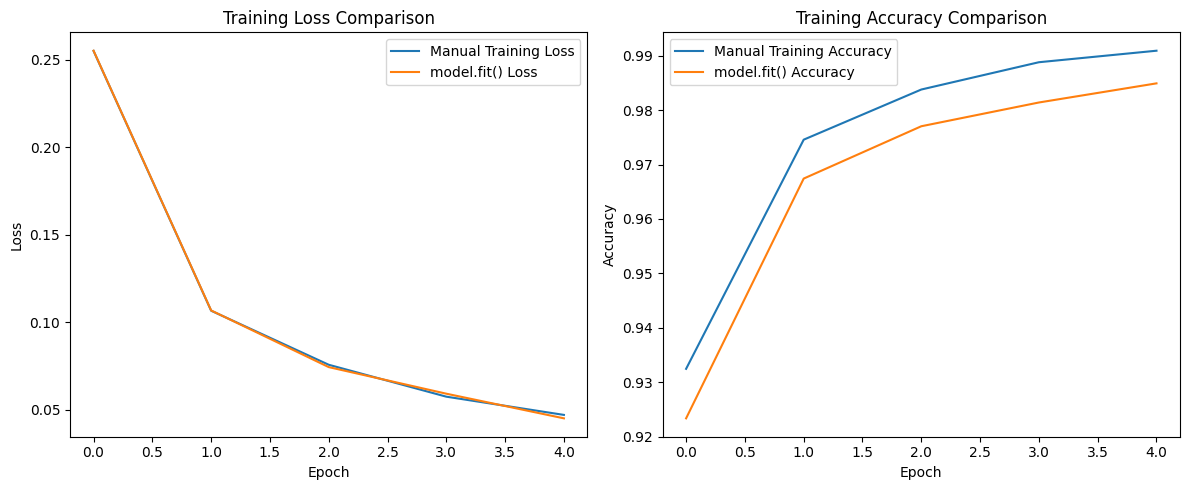

In [ ]:
plt.figure(figsize=(12,5))

# --- Training Loss ---
plt.subplot(1,2,1)
plt.plot(manual_loss_history, label='Manual Training Loss')
plt.plot(history.history['loss'], label='model.fit() Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# --- Training Accuracy ---
plt.subplot(1,2,2)
plt.plot(manual_acc_history, label='Manual Training Accuracy')
plt.plot(history.history['accuracy'], label='model.fit() Accuracy')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
